## 📊 Fiche Synthétique des Données

* **Source :** [Online Retail II (UCI Machine Learning Repository)](https://archive.ics.uci.edu/dataset/502/online-retail-ii)
* **Période couverte :** Du 01/12/2009 au 09/12/2011
* **Volume :** Environ 1,07 million de lignes (transactions)
* **Colonnes importantes :**
    * `Invoice`: Identifiant de la facture (essentiel pour regrouper les transactions).
    * `Quantity`: Quantité d'articles (essentiel pour le calcul du revenu).
    * `InvoiceDate`: Date de la transaction (base pour la Récence et les Cohortes).
    * `Price`: Prix unitaire (essentiel pour le calcul Monétaire).
    * `Customer ID`: Identifiant du client (base pour toute l'analyse RFM et CLV).

## Dictionnaire des Variables

Voici le détail des colonnes présentes dans le jeu de données :

| Nom de la Colonne | Type (Pandas) | Sémantique (Description) | Unités / Valeurs Exemples | |
| :--- | :--- | :--- | :--- | :--- |
| **Invoice** | `object` (string) | Identifiant unique de la facture. | `489434` |
| **StockCode** | `object` (string) | Identifiant unique du produit (SKU). | `85048` |
| **Description** | `object` (string) | Nom / description de l'article. | `PINK CHERRY LIGHTS` |
| **Quantity** | `int64` | Quantité d'articles pour cette ligne. | `12`, `48` |
| **InvoiceDate** | `datetime64[ns]` | Date et heure de la transaction. | `2009-12-01 07:45:00` |
| **Price** | `float64` | Prix unitaire de l'article. | `6.95`, `2.10` |
| **Customer ID** | `float64` | Identifiant unique du client. | `13085.0` |
| **Country** | `object` (string) | Pays de résidence du client. | `United Kingdom` |

## Qualité des données + Cleaning

#### Importation des librairies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Lecture du dataset

In [2]:
df1 = pd.read_excel('../data/raw/online_retail_II.xlsx', sheet_name='Year 2009-2010')
df2 = pd.read_excel('../data/raw/online_retail_II.xlsx', sheet_name='Year 2010-2011')

df = pd.concat([df1, df2], ignore_index=True)

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


#### Calcul et suppression des Doublons

In [4]:
df.duplicated().sum()

34335

In [5]:
df = df.drop_duplicates()

#### Calcul du pourcentage des valeurs manquantes par colonnes

In [6]:
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Colonnes': df.columns,
    'Nb manquants': missing_values,
    '% manquants': missing_percent
}).sort_values(by='% manquants', ascending=False)

In [ ]:
missing_df

,Colonnes,Nb manquants,% manquants
Customer ID,Customer ID,235151,22.763098
Description,Description,4275,0.413829
Invoice,Invoice,0,0.000000
StockCode,StockCode,0,0.000000
Quantity,Quantity,0,0.000000
InvoiceDate,InvoiceDate,0,0.000000
Price,Price,0,0.000000
Country,Country,0,0.000000


#### 🔍 Analyse des valeurs manquantes

**Résumé des résultats**

*Customer ID :*

* Nombre de valeurs manquantes : 243 007
* Pourcentage : 22,77 %
* Impact : Critique pour les analyses RFM et CLV (impossible d’identifier le client).
* **Décision :** Exclure ces lignes pour les analyses centrées sur le client, mais les conserver pour l’analyse globale des ventes.

*Description :*

* Nombre de valeurs manquantes : 4 382
* Pourcentage : 0,41 %
* Impact : Faible, n’affecte pas les métriques financières mais peut limiter l’analyse produit.
* **Décision :** Conserver les lignes (si StockCode est présent), ou imputer par “Unknown”.

*Autres colonnes :*

Aucun NaN détecté.

**Implications pour le projet**

Les analyses RFM, cohortes et CLV doivent être basées uniquement sur les transactions avec Customer ID non nul.
Prévoir un filtre “inclure/exclure clients anonymes” dans l’application Streamlit.

In [7]:
df = df.dropna(subset=['Customer ID'])

#### Granularité Temporelle
La colonne InvoiceDate a été convertie au format datetime

In [8]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")

#### Nombre de commandes annulées (Invoice commençant par 'C')

In [9]:
df['Invoice'].str.startswith('C').sum()

18390

**Résumé des résultats**

Nous avons identifié 18 390 lignes de transactions correspondant à des annulations (Invoice commençant par 'C'). Celles-ci ont des Quantity négatives. 

**Décision** : Conformément au brief du projet, ces lignes sont conservées dans le jeu de données final. Elles seront gérées via un filtre "Inclure/Exclure les retours" dans l'application Streamlit pour permettre à l'utilisateur de mesurer l'impact sur le revenu Net vs Brut.

#### suppression des prix = 0

In [10]:
df = df[df['Price'] > 0]
df = df.copy()

#### Changement du type (O --> str) + Suppression des tabulations avant/après 'Description'

In [11]:
df["Description"] = df["Description"].astype(str).str.strip()

#### création d'une colonne prix total (price * Quantity)

In [12]:
df['TotalPrice'] = df['Price'] * df['Quantity']

#### Forcer 'Invoice' et 'StockCode' à être de type str 

In [13]:
df['Invoice'] = df['Invoice'].astype(str)

In [14]:
df['StockCode'] = df['StockCode'].astype(str)

#### création d'un fichier .parquet contenant notre dataset nettoyé

l'extension .parquet permettra à notre application streamlit de lire les données plus rapidement

In [15]:
df.to_parquet("../data/processed/online_retail_clean.parquet", index=False)

# Graphiques visuels

##### Distribution par pays (10 premiers)

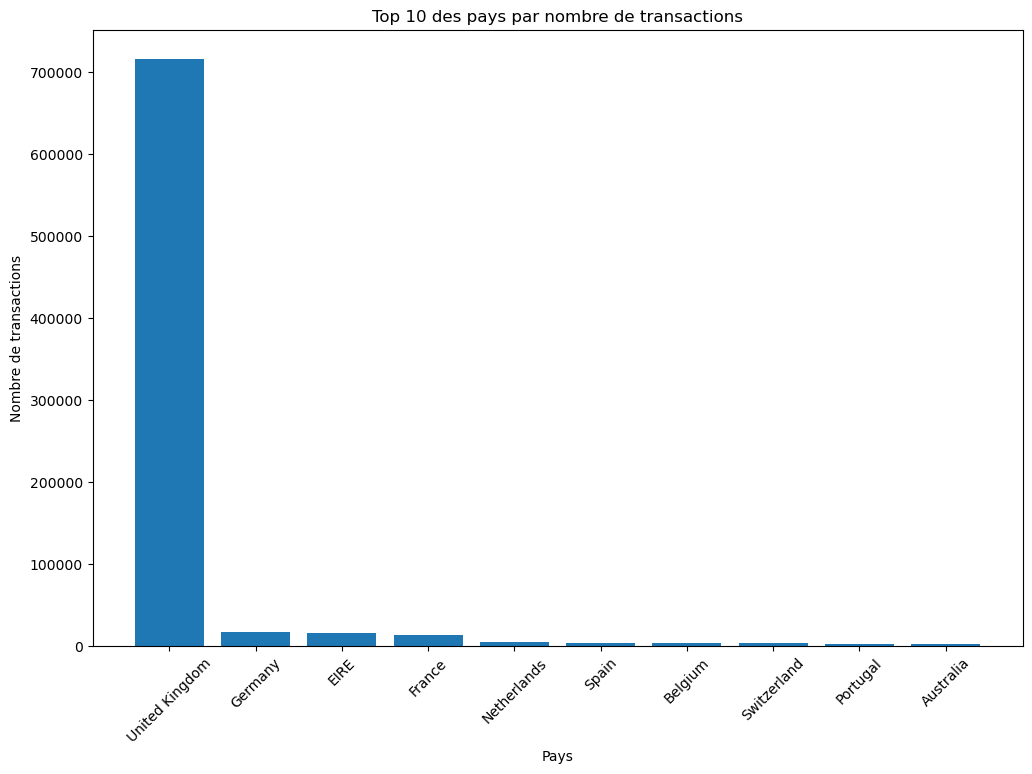

In [16]:
plt.figure(figsize=(12,8))
plt.bar(df['Country'].value_counts().head(10).index, df['Country'].value_counts().head(10).values)
plt.title('Top 10 des pays par nombre de transactions')
plt.xlabel('Pays')
plt.ylabel('Nombre de transactions')
plt.xticks(rotation=45)
plt.show()

Calcul du pourcentage de transactions venant du Royaume-Uni

In [17]:
pourcentage_uk = (df[df['Country']=='United Kingdom'].shape[0] * 100 / df.shape[0])
pourcentage_uk = round(pourcentage_uk, 1)
print(f'{pourcentage_uk}%')

89.8%


*Constat* 

* Les transactions concernent en très grande majorité le Royaume-Uni, avec près de 88% des transactions

##### Distribution du panier moyen

In [18]:
panier_moyen = df.groupby('Invoice')['TotalPrice'].sum()

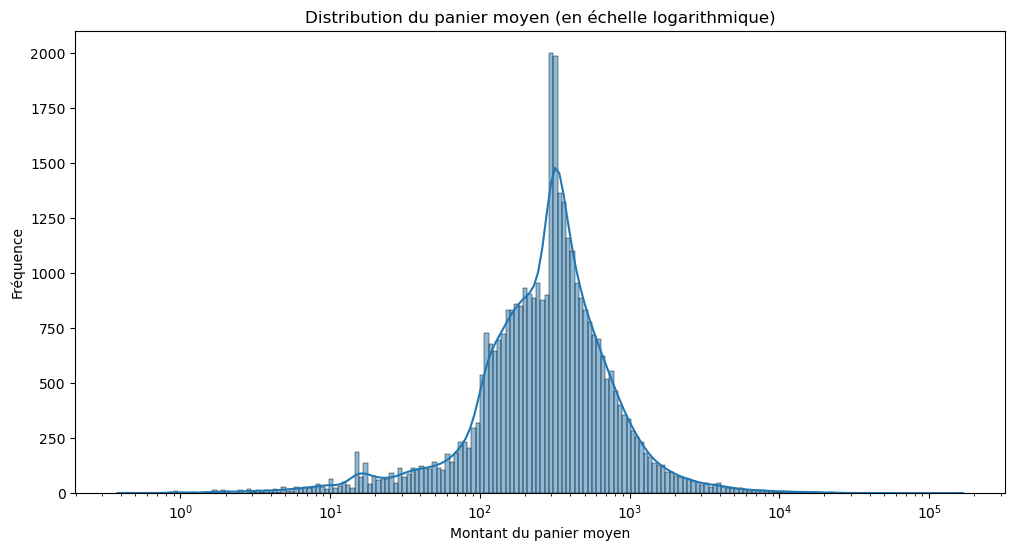

In [ ]:
plt.figure(figsize=(12,6))
sns.histplot(panier_moyen[panier_moyen > 0], kde=True, log_scale=True)
plt.title('Distribution du panier moyen (en échelle logarithmique)')
plt.xlabel('Montant du panier moyen')
plt.ylabel('Fréquence')
plt.show()

*Constat*

le montant du panier qui à le plus d'enregistrement se situe environ à 300. 

##### Distribution de la Fréquence d'Achat (Commandes par Client)

In [21]:
fréquence_achat = df.groupby('Customer ID')['Invoice'].nunique()

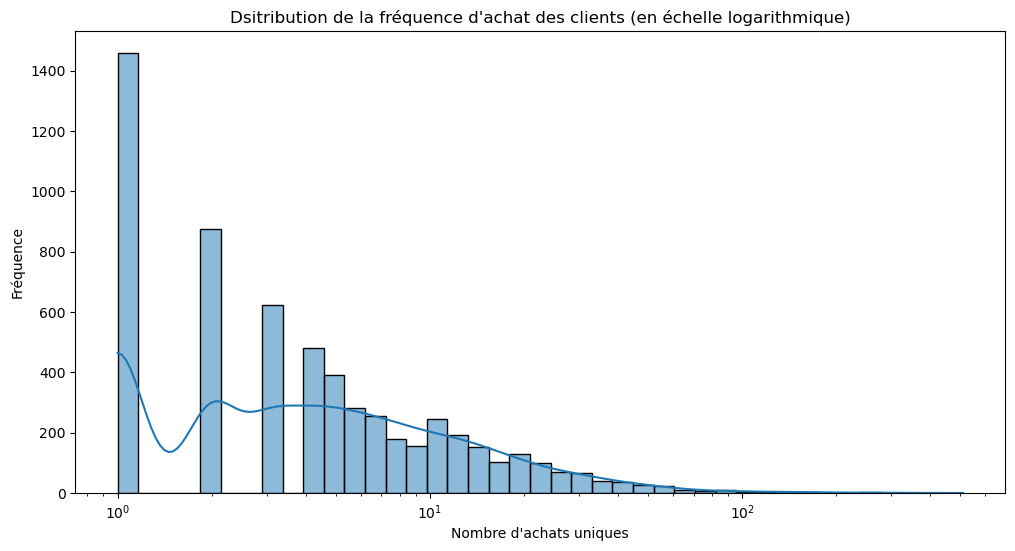

In [27]:
plt.figure(figsize=(12,6))
sns.histplot(fréquence_achat, kde=True, log_scale=True)
plt.title("Dsitribution de la fréquence d'achat des clients (en échelle logarithmique)")
plt.xlabel("Nombre d'achats uniques")
plt.ylabel('Fréquence')
plt.show()

*Constat*

La fréquence du nombre d'achats uniques par client est décroissante

##### Saisonnalité 

In [28]:
df['MonthYear'] = df['InvoiceDate'].dt.to_period('M')

nombre de transactions par mois

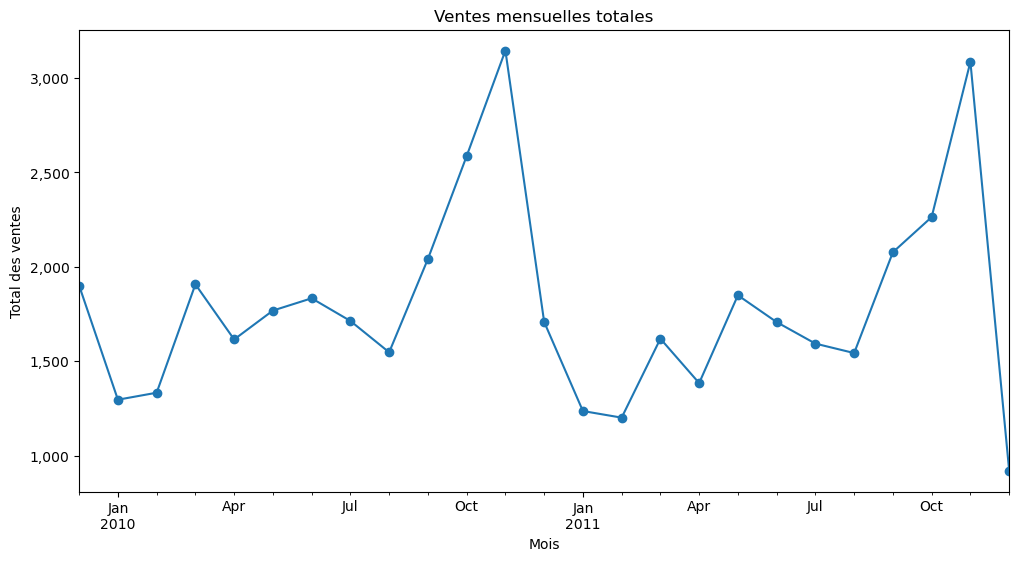

In [37]:
import matplotlib.ticker as ticker

ventes_mensuelles = df.groupby('MonthYear')['Invoice'].nunique()
plt.figure(figsize=(12,6))
ventes_mensuelles.plot(marker='o')
plt.title('Ventes mensuelles totales')
plt.xlabel('Mois')
plt.ylabel('Total des ventes')

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

Revenus totaux par mois

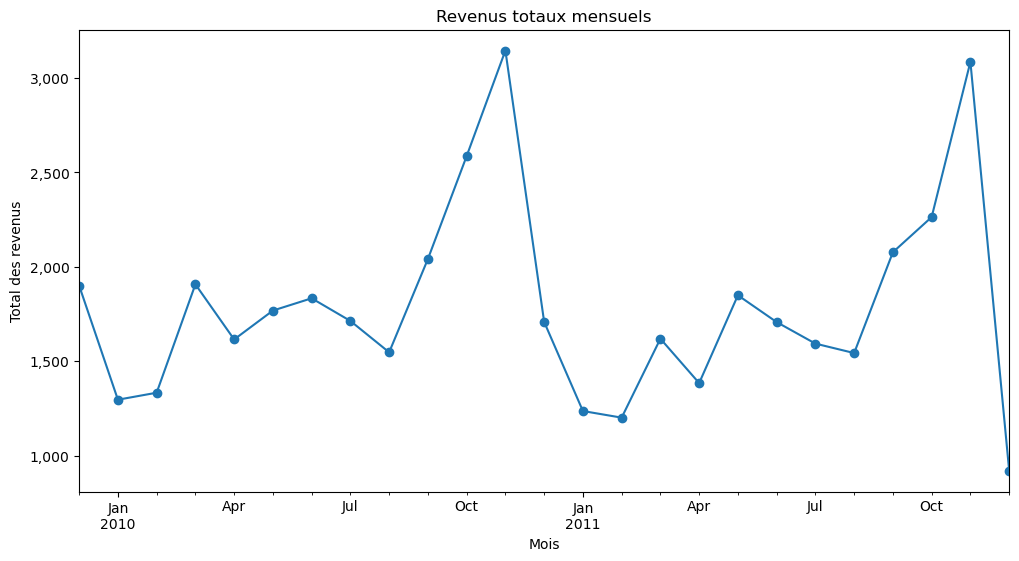

In [ ]:
revenus_mensuels = df.groupby('MonthYear')['TotalPrice'].sum()
plt.figure(figsize=(12,6))
revenus_mensuels.plot(marker='o')
plt.title('Revenus totaux mensuels')
plt.xlabel('Mois')
plt.ylabel('Total des revenus')

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

##### création d'une colonne 'Cohort' contenant tous les groupes de cohortes d'acquisition

In [6]:
df['Cohort'] = df.groupby('Customer ID')['InvoiceDate'].transform('min').dt.to_period('M')

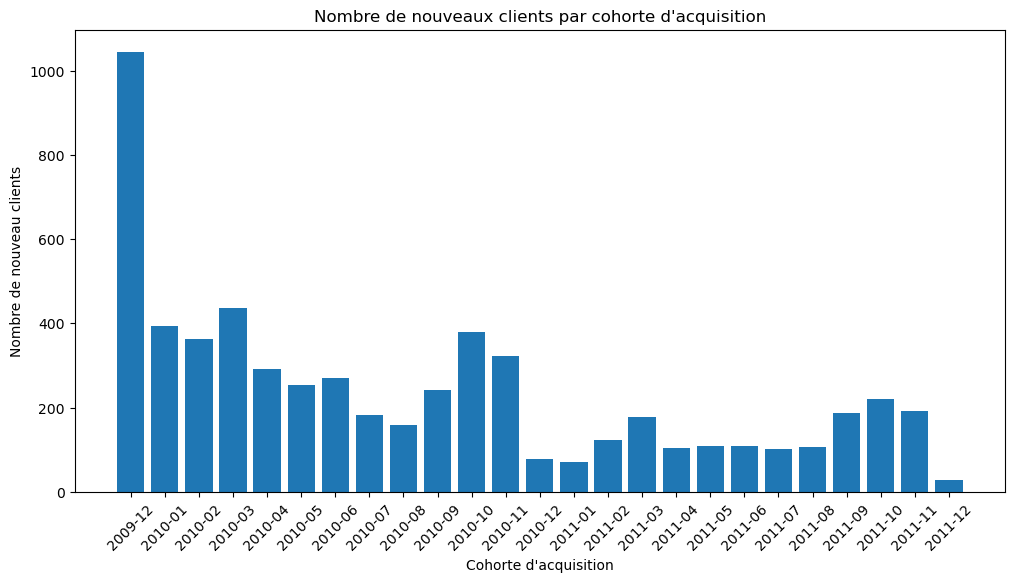

In [17]:
cohort_counts = df.groupby('Cohort')['Customer ID'].nunique()
plt.figure(figsize=(12,6))
plt.bar(cohort_counts.index.astype(str), cohort_counts.values)
plt.title("Nombre de nouveaux clients par cohorte d'acquisition")
plt.xlabel("Cohorte d\'acquisition")
plt.ylabel("Nombre de nouveau clients")
plt.xticks(rotation=45)
plt.show()